In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir('..')

import pickle
import re
from pathlib import Path
import json

import numpy as np
import pandas as pd

from tqdm import tqdm

pd.set_option('display.max_rows', 200)

import matplotlib as mpl
mpl.rcParams['font.size'] = 14           # Base font size
mpl.rcParams['axes.labelsize'] = 14      # Axis label font size
mpl.rcParams['axes.titlesize'] = 14      # Title font size
mpl.rcParams['xtick.labelsize'] = 12     # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 12     # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 13     # Legend font size

In [ ]:
df = pd.read_csv('./data/models_list.csv')
df

,Model name,Link to HF,"Params, B",Input hidden size,Vocabulary size,"Max capacity, tokens","PG-19, Gain, tokens","PG-19, CE Reduction","Random, Gain, tokens","Random, CE Reduction","Text CE (512 tokens, PG-19)","Estimated gain, tokens",PG19,Random
0,Pythia-160M,EleutherAI/pythia-160m,0.16,768,50304,787,71,396,61,501,1817.89,31.035920,0.090116,0.077914
1,Pythia-410M,EleutherAI/pythia-410m,0.41,1024,50304,1049,81,431,77,630,1609.67,45.949218,0.077501,0.073307
2,Pythia-1.4B,EleutherAI/pythia-1.4b,1.40,2048,50304,2098,158,793,144,1108,1486.78,131.688258,0.075308,0.068826
3,Pythia-2.8B,EleutherAI/pythia-2.8b,2.80,2560,50304,2623,150,740,134,1024,1424.14,128.400527,0.057234,0.051210
4,OPT-1.3B,facebook/opt-1.3b,1.30,2048,50272,2098,132,713,129,1066,1557.95,100.939973,0.063007,0.061625
5,OLMo-1B,allenai/OLMo-1B-0724-hf,1.00,2048,50304,2098,406,1901,257,1852,1470.72,846.843280,0.193657,0.122638
6,Sh.Llama-1.3B,princeton-nlp/Sheared-LLaMA-1.3B,1.30,2048,32000,2190,384,1835,315,1893,1400.06,845.747309,0.175198,0.143912
7,Llama-3.2-1B,meta-llama/Llama-3.2-1B,1.00,2048,128256,1931,426,2120,295,2265,1490.97,1131.615697,0.220705,0.152712
8,Llama-3.2-3B,meta-llama/Llama-3.2-3B,3.00,3072,128256,2897,720,3292,457,3383,1383.60,6704.461063,0.248668,0.157735
9,Llama-3.1-8B,meta-llama/Llama-3.1-8B,8.00,4096,128256,3862,1094,4866,623,4541,1266.66,66792.073920,0.283286,0.161360


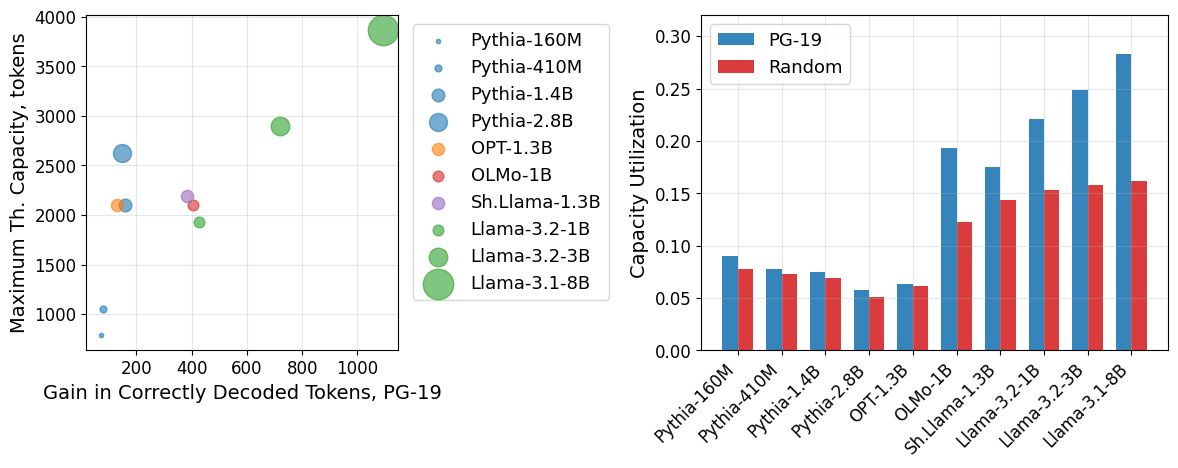

In [3]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.9), gridspec_kw={'width_ratios': [0.8, 1.2]})

# Define colors for each model family
colors = {
    'Pythia': '#1f77b4',  # blue
    'Sh.Llama': '#9467bd',  # purple
    'Llama': '#2ca02c',   # green 
    'OPT': '#ff7f0e',     # orange
    'OLMo': '#d62728',    # red
}

# Plot each unique model individually.
unique_models = df['Model name'].unique()
for model in unique_models:
    # Determine the family color by checking which family string is in the model name
    color = None
    for family, col in colors.items():
        if family in model:
            color = col
            break
    if color is None:
        color = 'gray'  # default if no match found

    mask = df['Model name'] == model
    ax1.scatter(df.loc[mask, 'PG-19, Gain, tokens'],
                df.loc[mask, 'Max capacity, tokens'],
                s=df.loc[mask, 'Params, B']*60,
                alpha=0.6,
                color=color,
                label=model)

# Remove duplicate legend entries (if a model appears more than once)
handles, labels = ax1.get_legend_handles_labels()
unique = {}
for handle, label in zip(handles, labels):
    if label not in unique:
        unique[label] = handle
ax1.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.02, 1), loc='upper left')

ax1.set_xlabel('Gain in Correctly Decoded Tokens, PG-19')
ax1.set_ylabel('Maximum Th. Capacity, tokens')
ax1.grid(True, alpha=0.3)

# Set width of bars and positions of the bars
bar_width = 0.35
models = df['Model name'].unique()
x = np.arange(len(models))

# Create bars in the same order as models array
pg19_scores = [df[df['Model name']==model]['PG19'].iloc[0] for model in models]
random_scores = [df[df['Model name']==model]['Random'].iloc[0] for model in models]

ax2.bar(x - bar_width/2, pg19_scores,
        bar_width, label='PG-19', color='#1f77b4', alpha=0.9)
ax2.bar(x + bar_width/2, random_scores,
        bar_width, label='Random', color='#d62728', alpha=0.9)

# Customize the plot
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel('Capacity Utilization')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim((0,0.32))

plt.tight_layout()
plt.savefig("notebooks/imgs/capacity_utilization.pdf", format='pdf', bbox_inches='tight')
plt.show()


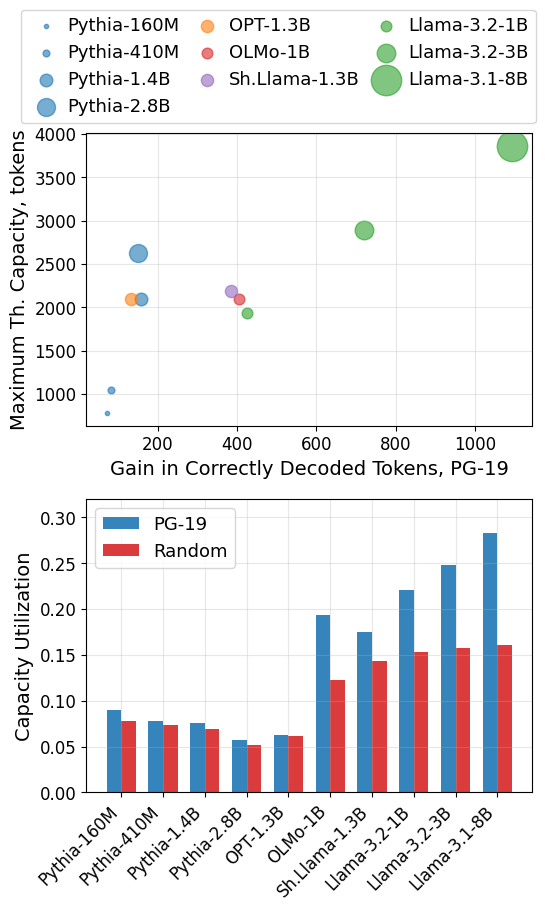

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6*0.95, 10*0.95))

# Define colors for each model family
colors = {
    'Pythia': '#1f77b4',  # blue
    'Sh.Llama': '#9467bd',  # purple
    'Llama': '#2ca02c',   # green 
    'OPT': '#ff7f0e',     # orange
    'OLMo': '#d62728',    # red
}

# Plot each unique model individually.
unique_models = df['Model name'].unique()
for model in unique_models:
    # Determine the family color by checking which family string is in the model name
    color = None
    for family, col in colors.items():
        if family in model:
            color = col
            break
    if color is None:
        color = 'gray'  # default if no match found

    mask = df['Model name'] == model
    ax1.scatter(df.loc[mask, 'PG-19, Gain, tokens'],
                df.loc[mask, 'Max capacity, tokens'],
                s=df.loc[mask, 'Params, B']*60,
                alpha=0.6,
                color=color,
                label=model)

# Remove duplicate legend entries (if a model appears more than once)
handles, labels = ax1.get_legend_handles_labels()
unique = {}
for handle, label in zip(handles, labels):
    if label not in unique:
        unique[label] = handle
# Place legend above the plot, spread horizontally
ax1.legend(unique.values(), unique.keys(), bbox_to_anchor=(0.43, 1.45), 
           loc='upper center', ncol=3, columnspacing=0.5, handletextpad=0.2)

ax1.set_xlabel('Gain in Correctly Decoded Tokens, PG-19')
ax1.set_ylabel('Maximum Th. Capacity, tokens')
ax1.grid(True, alpha=0.3)

# Set width of bars and positions of the bars
bar_width = 0.35
models = df['Model name'].unique()
x = np.arange(len(models))

# Create bars in the same order as models array
pg19_scores = [df[df['Model name']==model]['PG19'].iloc[0] for model in models]
random_scores = [df[df['Model name']==model]['Random'].iloc[0] for model in models]

ax2.bar(x - bar_width/2, pg19_scores,
        bar_width, label='PG-19', color='#1f77b4', alpha=0.9)
ax2.bar(x + bar_width/2, random_scores,
        bar_width, label='Random', color='#d62728', alpha=0.9)

# Customize the plot
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylabel('Capacity Utilization')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim((0,0.32))

plt.tight_layout()
plt.savefig("notebooks/imgs/capacity_utilization_v.pdf", format='pdf', bbox_inches='tight')
plt.show()
